### Implementing Mathworks Wind Turbine High-Speed Bearing Prognosis in Python.

Portions of the text and descriptions in this notebook are adapted from MathWorks documentation examples:<br>
https://www.mathworks.com/help/predmaint <br>
Used under MathWorks example code license.<br>

References:
- [Wind Turbine High-Speed Bearing Prognosis](https://www.mathworks.com/help/predmaint/ug/wind-turbine-high-speed-bearing-prognosis.html)

#### Feature Extraction

"Based on the analysis in the previous section, a collection of statistical features derived from time-domain signal and spectral kurtosis are going to be extracted."<br>

Note: We attempted to reproduce the Spectral Kurtosis computation exactly as in the MathWorks example, but results did not match even when using the same dataset and processing script. Due to these inconsistencies, we have excluded spectral kurtosis from our feature set.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy import signal
from scipy.stats import skew, kurtosis

In [ ]:
folder = "wind_turbine_pkl"

all_features = []

files = sorted([f for f in os.listdir(folder) if f.startswith("wt_") and f.endswith(".pkl")])

for file in files:
    with open(os.path.join(folder, file), "rb") as f:
        data = pickle.load(f)

    v = np.array(data["vibration"])

    # would compute spectral kurtosis here. 

    features = {
        "Date": data["date"],
        "Mean": np.mean(v),
        "Std": np.std(v),
        "Skewness": skew(v),
        "Kurtosis": kurtosis(v, fisher=True, bias=False),
        "Peak2Peak": np.ptp(v),
        "RMS": np.sqrt(np.mean(v**2)),
        "CrestFactor": np.max(np.abs(v)) / np.sqrt(np.mean(v**2)),
        "ShapeFactor": np.sqrt(np.mean(v**2)) / np.mean(np.abs(v)),
        "ImpulseFactor": np.max(np.abs(v)) / np.mean(np.abs(v)),
        "MarginFactor": np.max(np.abs(v)) / (np.mean(np.abs(v))**2),
        "Energy": np.sum(v**2),
        #"SKMean": sk_mean,
        #"SKStd": np.std(sk),
        #"SKSkewness": skew(sk),
        #"SKKurtosis": kurtosis(sk, fisher=True, bias=False),
    }

    all_features.append(features)

features_df = pd.DataFrame(all_features)
features_df.to_csv("wt_bearing_features.csv", index=False)


In [3]:
features_df.head()

,Date,Mean,Std,Skewness,Kurtosis,Peak2Peak,RMS,CrestFactor,ShapeFactor,ImpulseFactor,MarginFactor,Energy
0,2013-03-07 01:57:46,0.346052,2.270481,0.003870,-0.004378,21.621068,2.296702,4.914735,1.253517,6.160703,3.362451,3.090718e+06
1,2013-03-16 06:56:43,0.233177,1.984203,-0.001959,0.007185,18.831975,1.997857,5.048283,1.253975,6.330421,3.973352,2.338725e+06
2,2013-03-17 06:56:04,0.216575,2.113041,-0.001371,0.124720,21.857696,2.124111,5.485731,1.258684,6.904800,4.091575,2.643653e+06
3,2013-03-17 18:47:56,0.193808,2.133505,-0.012744,0.093440,21.588679,2.142290,5.319964,1.257507,6.689893,3.926914,2.689098e+06
4,2013-03-18 18:47:15,0.219193,2.128356,-0.000204,0.164703,24.050760,2.139613,5.788313,1.259477,7.290247,4.291382,2.682383e+06


#### Feature Postprocessing

"Extracted features are usually associated with noise. The noise with opposite trend can sometimes be harmful to the RUL prediction. In addition, one of the feature performance metrics, monotonicity, to be introduced next is not robust to noise. Therefore, a causal moving mean filter with a lag window of 5 steps is applied to the extracted features, where "causal" means no future value is used in the moving mean filtering."

In [4]:
features_df["Date"] = pd.to_datetime(features_df["Date"])
features_df = features_df.sort_values("Date").reset_index(drop=True)
features_df.head()

,Date,Mean,Std,Skewness,Kurtosis,Peak2Peak,RMS,CrestFactor,ShapeFactor,ImpulseFactor,MarginFactor,Energy
0,2013-03-07 01:57:46,0.346052,2.270481,0.003870,-0.004378,21.621068,2.296702,4.914735,1.253517,6.160703,3.362451,3.090718e+06
1,2013-03-08 02:34:21,0.244092,2.062146,0.003010,0.019467,19.309907,2.076542,4.912863,1.254461,6.162997,3.723132,2.526572e+06
2,2013-03-09 02:33:43,0.218729,2.103553,-0.001029,0.022406,21.474075,2.114894,5.214330,1.253927,6.538388,3.876629,2.620761e+06
3,2013-03-10 03:01:02,0.213717,2.008063,0.001477,0.041467,19.520002,2.019404,5.286041,1.255580,6.637048,4.126636,2.389443e+06
4,2013-03-11 03:00:24,0.215185,2.060562,0.001012,0.044484,21.216959,2.071768,5.235226,1.255376,6.572174,3.982370,2.514967e+06


In [5]:
def smooth_data(data, window_size):
    result = np.zeros_like(data, dtype=float)
    
    for i in range(len(data)):
        start_idx = max(0, i - window_size + 1)
        end_idx = i + 1  # being inclusive
        result[i] = np.mean(data[start_idx:end_idx])
    
    return result

features_df_smooth = features_df.copy()

for col in features_df.columns:
    if col != "Date":
        features_df_smooth[col] = smooth_data(features_df[col].values, window_size=7)



In [6]:
features_df_smooth.to_csv("wt_bearing_features_smooth.csv", index=False)

##### Plot what smoothing did

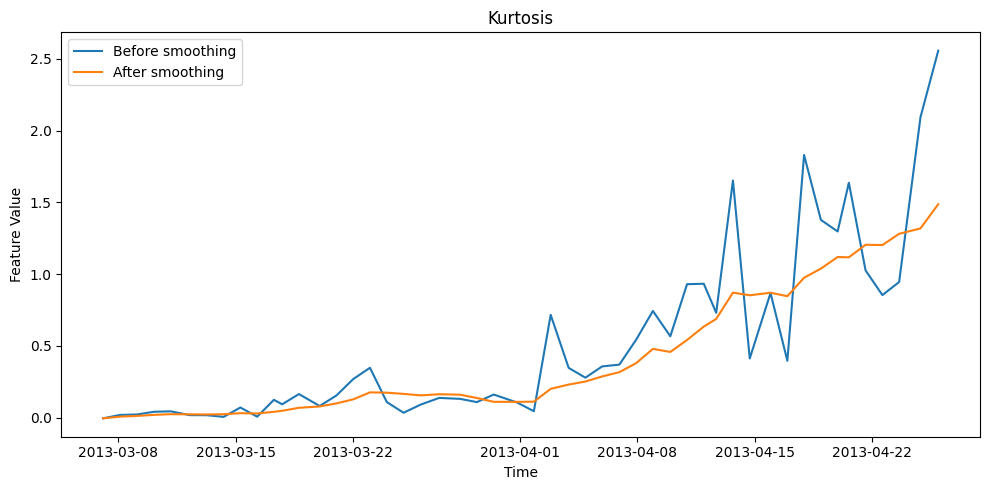

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(features_df["Date"], features_df["Kurtosis"], label="Before smoothing")
plt.plot(features_df_smooth["Date"], features_df_smooth["Kurtosis"], label="After smoothing")
plt.xlabel("Time")
plt.ylabel("Feature Value")
plt.title("Kurtosis")
plt.legend()
plt.tight_layout()
plt.show()


##### Training Data

"In practice, the data of the whole lifecycle is not available when developing the prognostic algorithm, but it is reasonable to assume that some data in the early stage of the lifecycle has been collected. Hence data collected in the first 20 days (40% of the lifecycle) is treated as training data. The following feature importance ranking and fusion is only based on the training data."

In [8]:
from datetime import datetime

breaktime = datetime(2013, 3, 27)

features_df_smooth["Date"] = pd.to_datetime(features_df_smooth["Date"])
breakpoint = features_df_smooth[features_df_smooth["Date"] < breaktime].index.max()

train_data = features_df_smooth.loc[:breakpoint].copy()

##### Feature Importance Ranking

In this example, monotonicity is used to quantify the merit of the features for prognosis purpose.
"...in this case n=50. m is the number of machines monitored, in this case m=1."

In [9]:
# based off the equation mathworks shows
def monotonicity(train_data):

    monotonicity_scores = {}
    n = len(train_data)

    for col in train_data.columns:
        x = train_data[col].values
        diffs = np.diff(x)
        pos = np.sum(diffs > 0)
        neg = np.sum(diffs < 0)
        score = abs(pos - neg) / (n - 1)
        monotonicity_scores[col] = score
    
    return pd.Series(monotonicity_scores)

numeric_train_data = train_data.select_dtypes(include=[np.number])

feature_importance = monotonicity(numeric_train_data)
print(feature_importance.sort_values(ascending=False))

Skewness         0.473684
Kurtosis         0.368421
ShapeFactor      0.368421
Mean             0.263158
ImpulseFactor    0.263158
MarginFactor     0.263158
Peak2Peak        0.157895
CrestFactor      0.157895
Std              0.052632
RMS              0.052632
Energy           0.052632
dtype: float64


"Features with feature importance score larger than 0.3 are selected for feature fusion in the next section."

In [10]:
selected_features = feature_importance[feature_importance > 0.3].index.tolist()

train_data_selected = train_data[['Date'] + selected_features]
feature_selected = features_df_smooth[['Date'] + selected_features]

##### Dimension Reduction and Feature Fusion

"Principal Component Analysis (PCA) is used for dimension reduction and feature fusion in this example. Before performing PCA, it is a good practice to normalize the features into the same scale. Note that PCA coefficients and the mean and standard deviation used in normalization are obtained from training data, and applied to the entire dataset."

In [11]:
import numpy as np
from sklearn.decomposition import PCA

X_train = train_data_selected.drop(columns='Date').values
X_full = feature_selected.drop(columns='Date').values

# normalize like its done in matworks
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)
X_train_norm = (X_train - mean_train) / std_train

pca = PCA()
pca.fit(X_train_norm)
X_full_norm = (X_full - mean_train) / std_train

PCA1 = X_full_norm @ pca.components_[0]
PCA2 = X_full_norm @ pca.components_[1]


In [12]:
print(PCA1)

[-2.43365101 -2.07914816 -1.68359276 -1.47023279 -1.32513201 -0.98113175
 -0.96470623 -0.8890301  -0.67250701 -0.66247957 -0.32147414  0.29505786
  0.4639186   0.71575171  1.26793822  1.80205112  2.72710609  2.57520006
  1.89830736  1.73775451  2.08207199  1.97111836  1.37826073  0.78080653
  0.9287421   0.93849218  2.94444458  3.35182593  3.79762756  4.50718241
  5.24914868  6.45388161  8.60299149  8.14402244  9.57228245 11.27790359
 12.88457655 16.12035241 15.83307272 16.37601883 15.74955374 18.1965754
 19.39258427 20.35618392 20.65572657 22.45826946 22.180968   24.02642442
 25.71389568 27.9150898 ]


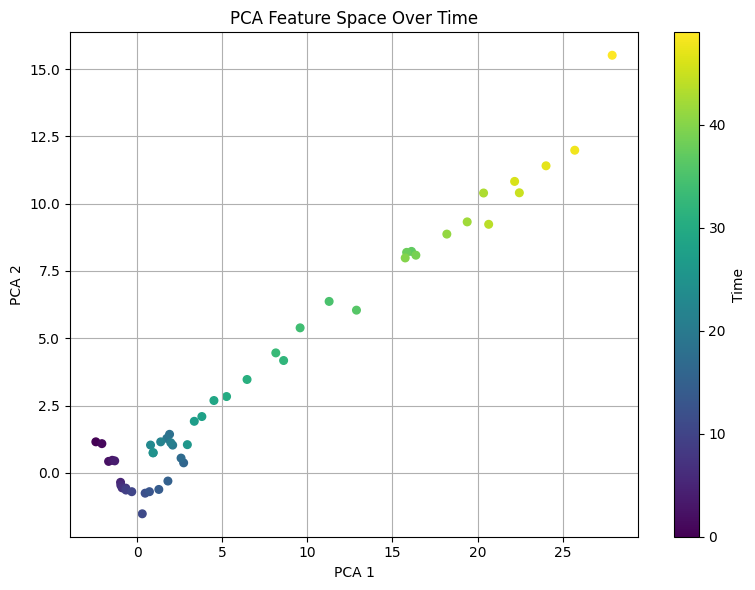

In [13]:
import matplotlib.pyplot as plt

num_data = len(PCA1)
color_vals = np.arange(num_data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(PCA1, PCA2, c=color_vals, cmap='viridis', s=30)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

cbar = plt.colorbar(scatter)
cbar.set_label('Time')

plt.title('PCA Feature Space Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


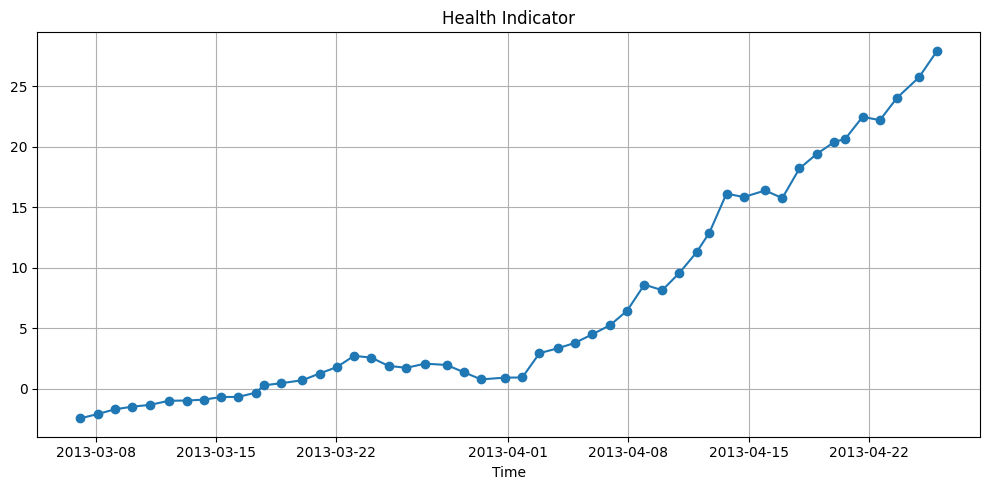

In [14]:
import matplotlib.pyplot as plt

health_indicator = PCA1

plt.figure(figsize=(10, 5))
plt.plot(feature_selected["Date"], health_indicator, marker='o', linestyle='-')
plt.xlabel("Time")
plt.title("Health Indicator")
plt.grid(True)
plt.tight_layout()
plt.show()


##### Fit Exponential Degradation Models for Remaining Useful Life (RUL) Estimation

In [15]:
health_indicator_shifted = health_indicator - health_indicator[0]
threshold = health_indicator_shifted[-1]

Fitted Parameters:
  θ = 0.730025
  β = 0.074682


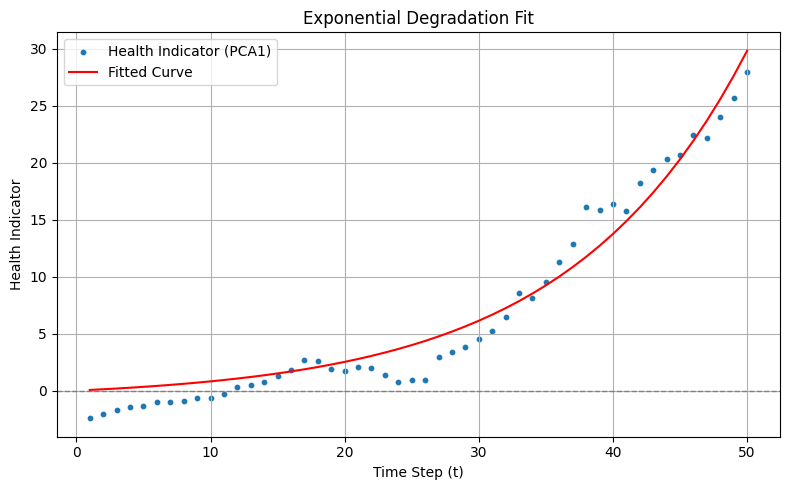

In [16]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

t = np.arange(1, len(health_indicator) + 1)

def degradation_model(t, theta, beta):
    return theta * (np.exp(beta * t)- 1)

initial_guess = [1.0, -0.01]
params, _ = curve_fit(degradation_model, t, health_indicator, p0=initial_guess)
theta_fit, beta_fit = params

print("Fitted Parameters:")
print(f"  θ = {theta_fit:.6f}")
print(f"  β = {beta_fit:.6f}")

plt.figure(figsize=(8, 5))
plt.scatter(t, health_indicator, label="Health Indicator (PCA1)", s=10)
plt.plot(t, degradation_model(t, *params), color='red', label="Fitted Curve")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Exponential Degradation Fit")
plt.xlabel("Time Step (t)")
plt.ylabel("Health Indicator")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
